# Transform collected YouTube Files to Trainingsdata
We want to use two kinds of trainingdata. First we want to split every song in junks of circa 0.5 seconds and use them as trainingsdata to generate new junks. These junks get sorted in a 2 dimensional field by our autoencoder. The structure of a song can then be imagened as a movement trough the 2 dimensional field. We will store these "movements", i.e. a list of coordinates and use these lists as trainingsdata for another network. Finally we want to be able to generate new "movements", i.e. new sequences of waveset-junks on the one hand and the corresponding junks themselves on the other hand.

## Wavesets
Every track from the training data gets split in wavesets with a duration of aprox. 0.2 second.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import librosa
import librosa.display
import soundfile
from IPython.display import display, Audio
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Waveset class
We split each song in multiple wavesets and create spectograms of them.
To train the autoencoder all spectograms have to be of the same size and have an even number of time-windows. The wavesets are of variable length, because the zero-crossing is a contigent feature. We can't be sure that all spectograms have the same number of time-windows. We have to check and pad if necessary:

In [2]:
class Wavesets:
    def __init__(self, path, min_size_fraction):
            self.data, self.sr = librosa.load(path, sr = None, mono = True)
            self.min_size = self.sr/min_size_fraction
            self.deleted_ws = 0

    def get_splitPoints(self, data):
        split_points = np.argwhere(
        (np.sign(data[:-1])==-1) & (np.sign(data[1:])==1)
        )
        return split_points
    
    def plot_wavesets(self, data, split_points, plot_range):
        data_range = data[plot_range[0]:plot_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data_range)
        plt.hlines(0.0, plot_range[0], plot_range[1], color='r')
        plt.vlines(split_points[(plot_range[0]<split_points) & (split_points<plot_range[1])], data_range.max(), data_range.min(), color='g')
        plt.xlabel("samples")
        plt.ylabel("amplitude")
        plt.title("Wavesets")
        plt.show();
        
    def resize_splits(self, splits, min_size):
        new_splits = []
        last_split = 0
        for split in splits:
            if (split - last_split) > min_size:
                last_split = split
                new_splits.append(split)
        return np.array(new_splits)
    

    def generate_wavesets(self, data, split_points):
        wavesets = []
        # we iterate over split points 2 times: once with no offset
        # and a 2nd time with an offset of 1 which gives us
        # the start and the end - zip allows us to iterate
        # over a collection of arrays in parallel
        for start, end in zip(split_points[:-1, 0], split_points[1:, 0]):
            waveset = data[start:end+1]
            waveset = self.apply_padding(waveset,(int(self.min_size + (self.sr*0.04))))
            if type(waveset) is np.ndarray:
                wavesets.append(waveset)
        return wavesets
    
    def get_Wavesets(self):
        split_points = self.get_splitPoints(self.data)
        split_points = self.resize_splits(split_points, self.min_size)
        #self.plot_wavesets(data, split_points, plot_range=[0, self.sr * 60 * 7])
        wavesets = self.generate_wavesets(self.data, split_points)
        wavesets = self.get_waveset_spectos(wavesets)
        return wavesets
    
    def get_waveset_spectos(self, wavesets):
        spectograms = []
        for ws in wavesets:
            spectogram = librosa.feature.melspectrogram(y=ws, sr=self.sr, hop_length=HOP_LENGTH, win_length=WIN_LENGTH, n_fft=N_FFT)
            spectogram = librosa.amplitude_to_db(spectogram)
            spectogram = spectogram[... , np.newaxis]
            spectograms.append(spectogram)
        return spectograms
    
    def apply_padding(self, waveset, max_length):
        missing_vals = max_length - waveset.shape[0]
        
        if missing_vals >= 0:
            waveset = np.pad(waveset, (0 , missing_vals), 'constant', constant_values=(0,0))
            return waveset
        else:
            #print(f"WARNING: One Waveset is too long: {path}. It has {-missing_vals} more samples then max_length and gets dropped.")
            self.deleted_ws += 1
            return None

        
        

### Generate Wavesets
We can now generate all Wavesets. Later we want to be able to reconstruct the position of each waveset in the song. For this, we store how many wavesets each song is split into.

In [3]:
sr = 44100
WIN_LENGTH = int(sr/30)
HOP_LENGTH = int(sr/60)
N_FFT = int(sr/20)


folder_path = 'H:\Musik\CD-Sammlung wavs\Music'
paths = librosa.util.find_files(folder_path, ext=['wav'])

all_wavesets = []
num_of_ws_per_song = []
deleted_wavesets = 0

for i,path in enumerate(paths): 
    waveset_generator = Wavesets(path, 2)
    wavesets = waveset_generator.get_Wavesets() # The variable "wavesets" is a list of np-arrays (with the amplitudes stored in it).
    deleted_wavesets += waveset_generator.deleted_ws
    all_wavesets.extend(list(wavesets))  # all wavesets is a list of all wavesets
    num_of_ws_per_song.append(len(wavesets)) # a list of the number of wavesets each song has
    print(f"{i+1} of {len(paths)} songs done." + f" Currently working on file:{path}", end='\r')

In [4]:
print(f"We've extracted {len(all_wavesets)} wavesets out of {len(paths)} songs.")
print(f"We had to delete {deleted_wavesets} wavesets, because they were too long")

We've extracted 282218 wavesets out of 496 songs.
We had to delete 200 wavesets, because they were too long


We can double check, that all spectograms have the same shape:

In [5]:
for i,ws in enumerate(all_wavesets):
    if not (ws.shape == all_wavesets[0].shape):
        #print("Something went wrong!")
        print(f"{ws.shape[0] - all_wavesets[0].shape[0]} in dim 0 and {ws.shape[1]- all_wavesets[1].shape[1]} in dim 1")
        print(f"Error occured in waveset {i}")

We can look at the spectogram of a random waveset to see that everything works.

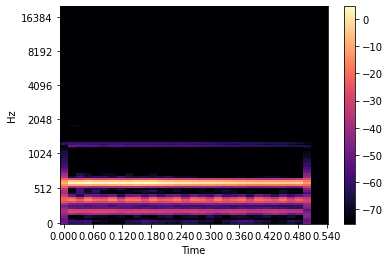

In [6]:
librosa.display.specshow(
    all_wavesets[np.random.randint(0,len(all_wavesets))].reshape(all_wavesets[0].shape[0],all_wavesets[0].shape[1]),
    x_axis='time',
    y_axis='mel',
    sr=sr,
    fmax=20000,
    hop_length=HOP_LENGTH,
)
plt.colorbar()
plt.show()

We do not normalize our samples, because we want to preserve the loudness of each waveset

### Create Song-Label for Wavesets
We need another array that stores the information which waveset belongs to which song

In [7]:
song_labels = np.empty(len(all_wavesets))

start_ws = 0
stop_ws = 0

for i, num_of_ws in enumerate(num_of_ws_per_song):
    stop_ws += num_of_ws
    song_labels[start_ws : stop_ws] = i
    start_ws += num_of_ws
    print(f"{((i+1)/len(num_of_ws_per_song)) * 100}% done", end = "\r")
    

### Create position data
We also want to know, at which position in the song a waveset occured. For this we split the song in 4 parts and create a label 0,1,2 or 3 for each waveset.

In [8]:
position_labels = np.empty(len(all_wavesets))

start_ws = 0
stop_ws = 0

for i, num_of_ws in enumerate(num_of_ws_per_song):
    for j in range(4):
        stop_ws += int((num_of_ws/4))
        position_labels[start_ws : stop_ws] = j+1
        start_ws = stop_ws
    print(f"{((i+1)/len(num_of_ws_per_song)) * 100}% done", end = "\r")

position_labels.shape

(282218,)

### Save Data
We save the data on disk for later use.

In [12]:
save_path = "data\spectos.npy"
np.save(save_path,all_wavesets)

save_path2 = "data\song_labels.npy"
np.save(save_path2, song_labels)

save_path3 = "data\position_labels.npy"
np.save(save_path3, position_labels)

save_path4 = "data\numOfWs.npy"
np.save(save_path4, num_of_ws_per_song)

OSError: [Errno 22] Invalid argument: 'data\numOfWs.npy'